In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm
# Set random seed for reproducibility
manualSeed = 555

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  555


2-Definition of Hyper Parameters

In [8]:
path = "C:/Users/ngold/Downloads/animelite/"

workers = 3 # Number of workers
batch_size = 128
image_size = 64
nz = 100 # Size of z latent vector
num_epochs = 3
lr = 0.001
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers

3-Import Dataset

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = torchvision.datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

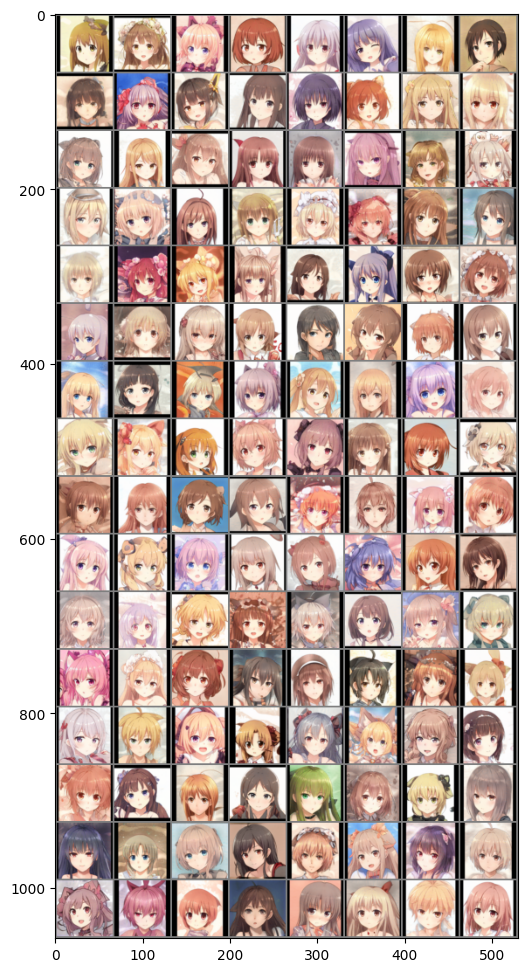

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader )
images, labels = next(dataiter)
plt.figure(figsize=(12,12))
# show images
imshow(torchvision.utils.make_grid(images))

Definir el modelo

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #IF WE HAVE GPU WE CAN USE It

Clase Discriminadora

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
            # input is `3x 64 x 64``
        self.conv1=nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
            
            # ``64 x 32 x 32``
        self.conv2= nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.btn2=nn.BatchNorm2d(128)
        self.relu2=nn.LeakyReLU(0.2, inplace=True)
            
            # ``128 x 16 x 16``
        self.conv3= nn.Conv2d(128,256, 4, 2, 1, bias=False)
        self.btn3=nn.BatchNorm2d(256)
        self.relu3=nn.LeakyReLU(0.2, inplace=True)
            
            # ``256 x 8 x 8``
        self.conv4= nn.Conv2d(256,512, 4, 2, 1, bias=False)
        self.btn4=nn.BatchNorm2d(512)
        self.relu4=nn.LeakyReLU(0.2, inplace=True)
            
            # 512 x 4 x 4``
        self.conv5= nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        self.sig=nn.Sigmoid()
        

    def forward(self, Input):
        output=self.conv1(Input)
        output=self.relu1(output)
        
        output=self.conv2(output)
        output=self.btn2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.btn3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.btn4(output)
        output=self.relu4(output)
        
        output=self.conv5(output)
        output=self.sig(output)
        
        return output
        

Clase generadora

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        

        self.convt1=nn.ConvTranspose2d( 100, 512, 4, 1, 0, bias=False)
        self.btnt1=nn.BatchNorm2d(512)
        self.relut1=nn.ReLU(True)
            
            # ``512*4*4``
        self.convt2=nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
        self.btnt2=nn.BatchNorm2d(256)
        self.relut2=nn.ReLU(True)
            
            # ``256*8*8``
        self.convt3=nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
        self.btnt3=nn.BatchNorm2d(128)
        self.relut3=nn.ReLU(True)
            
            # ``128*16*16``
        self.convt4=nn.ConvTranspose2d(128,64, 4, 2, 1, bias=False)
        self.btnt4=nn.BatchNorm2d(64)
        self.relut4=nn.ReLU(True)
            
            # 64*32*32``
        self.convt5= nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)
        self.tan=nn.Tanh()
        
     # 3*64*64``
    def forward(self, Input):
        output=self.convt1(Input)
        output=self.btnt1(output)
        output=self.relut1(output)
        
        output=self.convt2(output)
        output=self.btnt2(output)
        output=self.relut2(output)
        
        output=self.convt3(output)
        output=self.btnt3(output)
        output=self.relut3(output)
        
        output=self.convt4(output)
        output=self.btnt4(output)
        output=self.relut4(output)
        
        output=self.convt5(output)
        output=self.tan(output)
        
        return output

4-3- Weights Initialization

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

5-Creating & Training Networks

5-1-Creating Networks

In [15]:
netD = Discriminator().to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda'):
    netD = nn.DataParallel(netD)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (sig): Sigmoid()
)


In [16]:
netG = Generator().to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda'):
    netG = nn.DataParallel(netG)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (btnt1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut1): ReLU(inplace=True)
  (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btnt2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut2): ReLU(inplace=True)
  (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btnt3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut3): ReLU(inplace=True)
  (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btnt4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut4): ReLU(inplace=True)
  (convt5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tan): Tanh

5-2-Training Networks

In [17]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

def plot_results():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [18]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: 
     
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/3][0/201]	Loss_D: 2.0848	Loss_G: 26.6438	D(x): 0.6611	D(G(z)): 0.7371 / 0.0000
[0/3][50/201]	Loss_D: 0.9916	Loss_G: 2.4831	D(x): 0.5872	D(G(z)): 0.1785 / 0.1175
[0/3][100/201]	Loss_D: 1.7369	Loss_G: 1.7387	D(x): 0.3119	D(G(z)): 0.0186 / 0.3554
[0/3][150/201]	Loss_D: 1.1134	Loss_G: 2.4489	D(x): 0.4568	D(G(z)): 0.0463 / 0.1204
[0/3][200/201]	Loss_D: 0.6505	Loss_G: 4.0088	D(x): 0.7570	D(G(z)): 0.2605 / 0.0237
[1/3][0/201]	Loss_D: 1.0486	Loss_G: 5.6261	D(x): 0.7711	D(G(z)): 0.4715 / 0.0059
[1/3][50/201]	Loss_D: 1.7093	Loss_G: 2.7536	D(x): 0.3048	D(G(z)): 0.0274 / 0.1294
[1/3][100/201]	Loss_D: 1.6923	Loss_G: 7.4978	D(x): 0.8932	D(G(z)): 0.7381 / 0.0013
[1/3][150/201]	Loss_D: 1.1731	Loss_G: 1.5381	D(x): 0.4554	D(G(z)): 0.2201 / 0.2910
[1/3][200/201]	Loss_D: 1.2537	Loss_G: 2.0904	D(x): 0.5170	D(G(z)): 0.3504 / 0.1754
[2/3][0/201]	Loss_D: 1.2405	Loss_G: 3.9380	D(x): 0.6715	D(G(z)): 0.5095 / 0.0272
[2/3][50/201]	Loss_D: 0.8817	Loss_G: 3.5526	D(x): 0.8084	D(G(z)): 0.4472 / 0.0393
[2/3][100/20

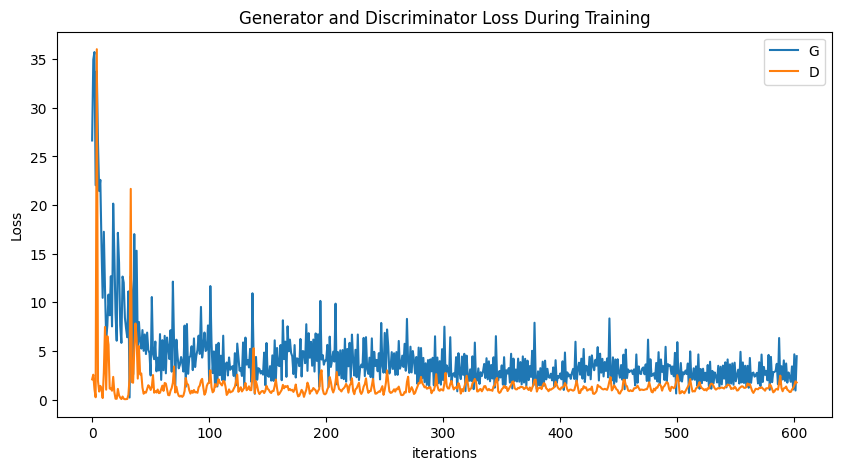

In [19]:
plot_results()

Generar Imagenes 

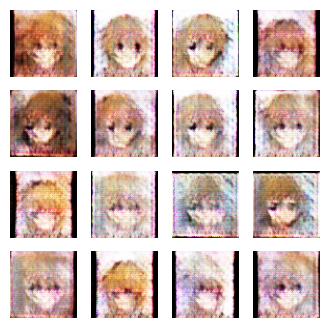

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Función para generar y guardar imágenes
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input).detach().cpu()
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.transpose(vutils.make_grid(predictions[i], padding=2, normalize=True), (1, 2, 0)))
        plt.axis('off')
    plt.savefig(f"image_at_epoch_{epoch:04d}.png")
    plt.show()

# Generar imágenes
noise = torch.randn(16, 100, 1, 1, device=device)
generate_and_save_images(netG, num_epochs, noise)


Visualizar imagenes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

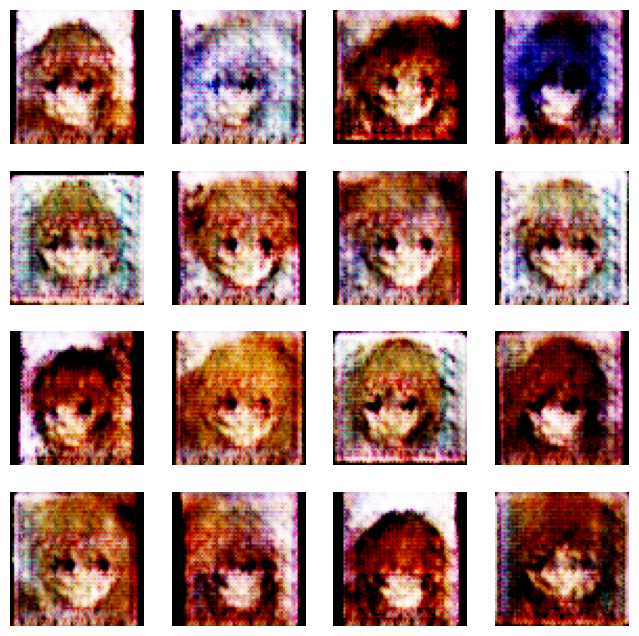

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Generar imágenes
noise = torch.randn(16, 100, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()

# Visualizar imágenes
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(fake_images[i], (1, 2, 0)))
    ax.axis('off')
plt.show()
